In [1]:
import glob

import numpy as np
import matplotlib.pyplot as plt
#from mpl_toolkits.axes_grid1 import ImageGrid

from astropy import wcs
from astropy.io import fits
import astropy.units as u
from astropy.visualization import simple_norm
from astropy.table import QTable

from photutils.aperture import CircularAperture, CircularAnnulus
# from photutils.aperture import aperture_photometry
from photutils.detection import DAOStarFinder

from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.stats import sigma_clipped_stats

# specific functions for this work
from helpers import get_aper_flux, disp_subimages

Source details

In [2]:
sourcecoords = "5:05:30.62  +52:49:54.0"   # nominal source location
# sourcecoords = "76.377584   52.830871"
sourcename = "g191b2b"
aorid = "r28510976"
aprads = [3.0, 3.0, 7.0]  # source radius, sky inner/outer radii
apcors = [1.125, 1.120, 1.135, 1.221]

Determine the source position based on default coordinates and centroiding on nearest source

 id     xcentroid      ...        flux               mag        
--- ------------------ ... ----------------- -------------------
  1 25.198334363128744 ... 2.434867980644076 -0.9661885464925228


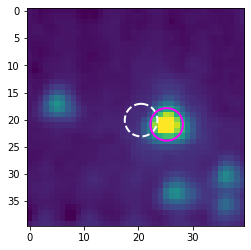

In [3]:
mosfilename = glob.glob(f"data/{sourcename}/{aorid}/ch1/pbcd/SPITZER_I1_*_maic.fits")[0]
center = SkyCoord(sourcecoords, unit=(u.hourangle, u.deg))
# center = SkyCoord(sourcecoords, unit=(u.deg, u.deg))
# use the mosaic to refine the source coordinates
moshdul = fits.open(mosfilename)
mosimage_orig = moshdul[0].data
mosw = wcs.WCS(moshdul[0].header)
moscenter = mosw.world_to_pixel(center)
mc = np.rint(moscenter).astype(int)

subsize = 40
mosimage_cutout = Cutout2D(mosimage_orig, mc, [subsize, subsize], wcs=mosw)
mosimage = mosimage_cutout.data

mean = np.nanmean(mosimage)
std = np.nanstd(mosimage)
daofind = DAOStarFinder(fwhm=2.0, threshold=5.*std)  
sources = daofind(mosimage - mean)
print(sources)

norm = simple_norm(mosimage, 'sqrt', percent=99)
plt.imshow(mosimage, norm=norm, interpolation='nearest')

# original position
center_pix = center.to_pixel(mosimage_cutout.wcs)
aperture = CircularAperture(center_pix, r=aprads[0])
ap_patches = aperture.plot(color='white', lw=2, linestyle="dashed",
                           label='Photometry aperture')
sindx = 0
new_center_pix = [sources["xcentroid"][sindx], sources["ycentroid"][sindx]]
new_aperture = CircularAperture(new_center_pix, r=aprads[0])
ap_patches = new_aperture.plot(color='magenta', lw=2,
                           label='Photometry aperture')

new_center = mosimage_cutout.wcs.pixel_to_world(new_center_pix[0], new_center_pix[1])

Perform aperture photometry and display cutouts with the apertures used

In [4]:
allchfiles = [np.sort(glob.glob(f"data/{sourcename}/{aorid}/ch{i}/bcd/SPITZER_I{i}_*_bcd.fits")) for i in np.arange(1, 5)]

chsfluxes = []
chscorfacs1 = []
chscorfacs2 = []
chsfiles = []
chsx = []
chsy = []
medbkgs = []
totbkgs = []
for k, allfiles in enumerate(allchfiles):
    sfluxes = []
    corfac1 = []
    corfac2 = []
    medbkg = []
    totbkg = []
    files = []
    x = []
    y = []
    for cfilename in allfiles:
        hdul = fits.open(cfilename)
        image = hdul[0].data
        w = wcs.WCS(hdul[0].header)

        # pixscales = np.absolute([hdul[0].header["PXSCAL1"], hdul[0].header["PXSCAL2"]]) / 3600.
        # pix_area_sr = (pixscales[0]*pixscales[1])*((np.pi/180.0))**2
        pix_area_sr = w.proj_plane_pixel_area().to(u.sr).value
        conv_fac = 1e9*pix_area_sr  # convert from MJy/sr to mJy/pixel  
        image *= conv_fac
        
        center_pix = new_center.to_pixel(w)
        isize = image.shape
        if (0 < center_pix[0] < isize[0]) & (0 < center_pix[1] < isize[1]):
            aperture = CircularAperture(center_pix, r=aprads[0])
            annulus_aperture = CircularAnnulus(center_pix, r_in=aprads[1], r_out=aprads[2])
            cflux = get_aper_flux(image, aperture, annulus_aperture, center_pix, k)
            sfluxes.append(cflux[0]*apcors[k])
            corfac1.append(cflux[1])
            corfac2.append(cflux[2])
            medbkg.append(cflux[3])
            totbkg.append(cflux[4]*apcors[k]*cflux[1]*cflux[2])  # apply same corrections as aperture fluxes
            files.append(cfilename)
            x.append(center_pix[0])
            y.append(center_pix[1])
    chsfluxes.append(sfluxes)
    chscorfacs1.append(corfac1)
    chscorfacs2.append(corfac2)
    medbkgs.append(medbkg)
    totbkgs.append(totbkg)
    chsfiles.append(files)
    chsx.append(x)
    chsy.append(y)

ch1 2.0211106601757396 mJy 0.03344003981140896 mJy 0.004353522366202727 mJy 464.24722102406764 0.13579190427239718 mJy 59
ch2 1.2777152457007537 mJy 0.025101954444366092 mJy 0.0032679961126022734 mJy 390.9782024444703 0.1216434383452486 mJy 59
ch3 0.794398269184754 mJy 0.06286904496672101 mJy 0.008184852498621855 mJy 97.05712709160156 1.9147803343227483 mJy 59
ch4 0.4170507649808281 mJy 0.06903865883382732 mJy 0.009394971481609293 mJy 44.39084948764424 5.073725643009794 mJy 54
<SkyCoord (ICRS): (ra, dec) in deg
    (76.3776, 52.83087)>


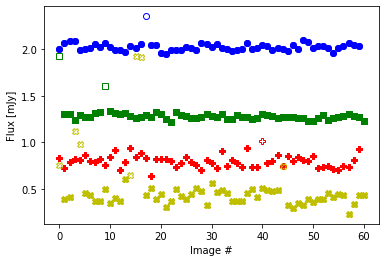

In [5]:
from astropy.stats import sigma_clip

aphot = QTable(names=("channel", "flux", "stddev", "mean_stddev", "SNR", "mean_bkg", "npts"),
               dtype=("int", "float", "float", "float", "float", "float", "int"),
               units=("", "mJy", "mJy", "mJy", "", "mJy", ""))

ptype = ['bo', 'gs', 'rP', 'yX']
chfiltered = []
np.set_printoptions(precision=5)
for i, sfluxes in enumerate(chsfluxes):
    plt.plot(np.arange(len(sfluxes)), sfluxes, ptype[i], fillstyle="none")

    filtered_data = sigma_clip(sfluxes, sigma=3, maxiters=5, masked=True)
    chfiltered.append(filtered_data)
 
    # make and output an astropy table
    ophot = QTable()
    nfluxes = len(sfluxes)
    ophot["AOR"] = [aorid] * nfluxes
    ophot["channel"] = [i+1] * nfluxes
    ophot["pix_x"] = chsx[i]
    ophot["pix_y"] = chsy[i]
    ophot["flux"] = sfluxes * u.mJy
    ophot["pointgaincor"] = chscorfacs1[i]
    ophot["pixelphasecor"] = chscorfacs2[i]
    ophot["median_bkg"] = medbkgs[i] * u.mJy
    ophot["total_bkg"] = totbkgs[i] * u.mJy
    ophot["mask"] = filtered_data.mask
    ophot["filename"] = chsfiles[i]
    ophot.write(f"data/{sourcename}/{sourcename}_{aorid}_ch{i+1}_phot.dat", format="ipac", overwrite=True)

    plt.plot(np.arange(len(sfluxes)), filtered_data, ptype[i])

    mean = np.mean(filtered_data) * u.mJy
    stddev = np.std(filtered_data) * u.mJy
    stdmean = stddev / np.sqrt(len(filtered_data[~filtered_data.mask]))
    tbkgs = np.ma.masked_array(totbkgs[i], mask=filtered_data.mask)
    meanbkg = np.mean(tbkgs) * u.mJy
    print(f"ch{i+1}", mean, stddev, stdmean, mean/stdmean, meanbkg, len(filtered_data[~filtered_data.mask]))
    aphot.add_row([i+1, mean, stddev, stdmean, mean/stdmean, meanbkg, len(filtered_data[~filtered_data.mask])])

aphot.write(f"data/{sourcename}/{sourcename}_{aorid}_ave_phot.dat", format="ipac", overwrite=True)
               
plt.xlabel("Image #")
plt.ylabel("Flux [mJy]")

print(new_center)

Display cutouts of each image showing the apertures used

Red sky annulii indicate measurements that were sigma clip rejected

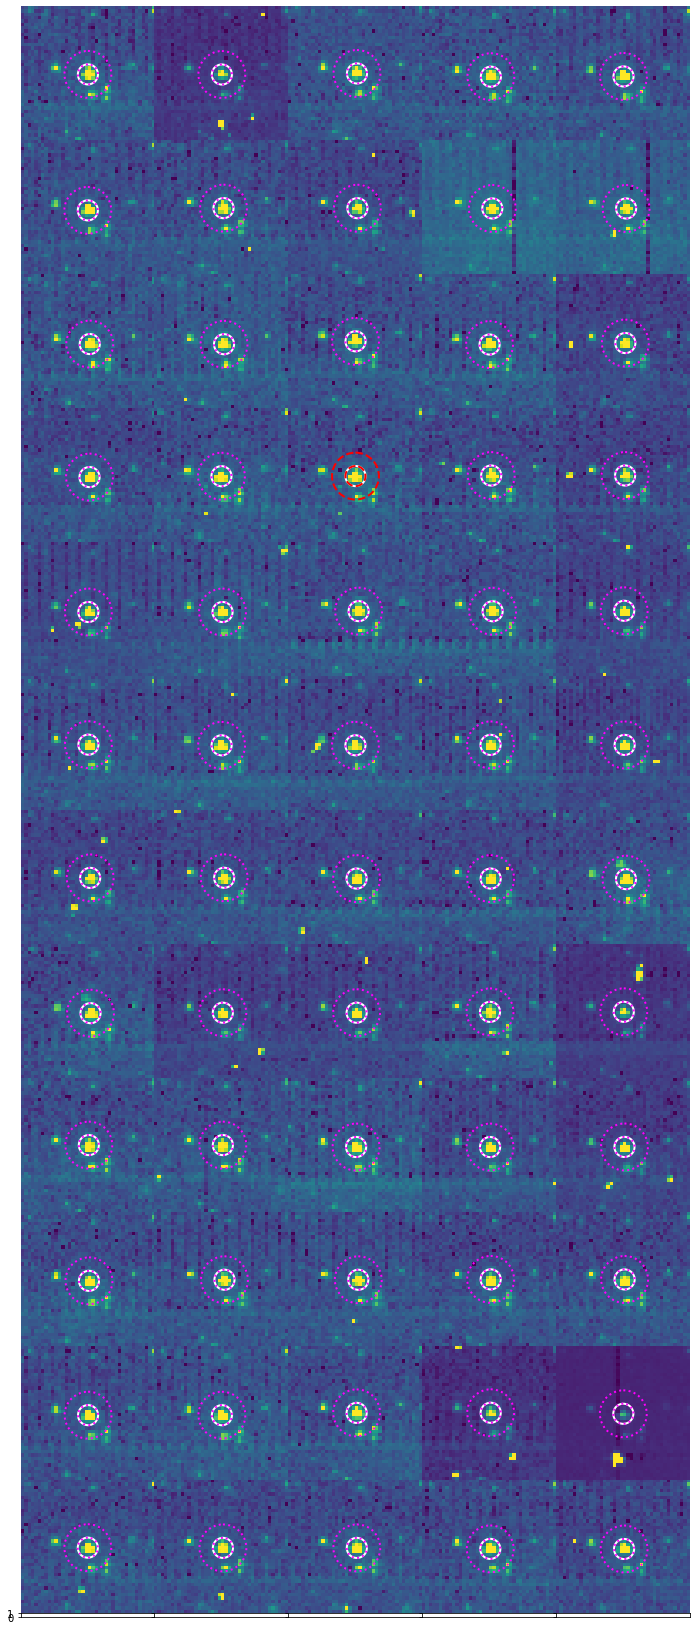

In [6]:
disp_subimages(allchfiles[0], chfiltered[0], aprads, new_center)

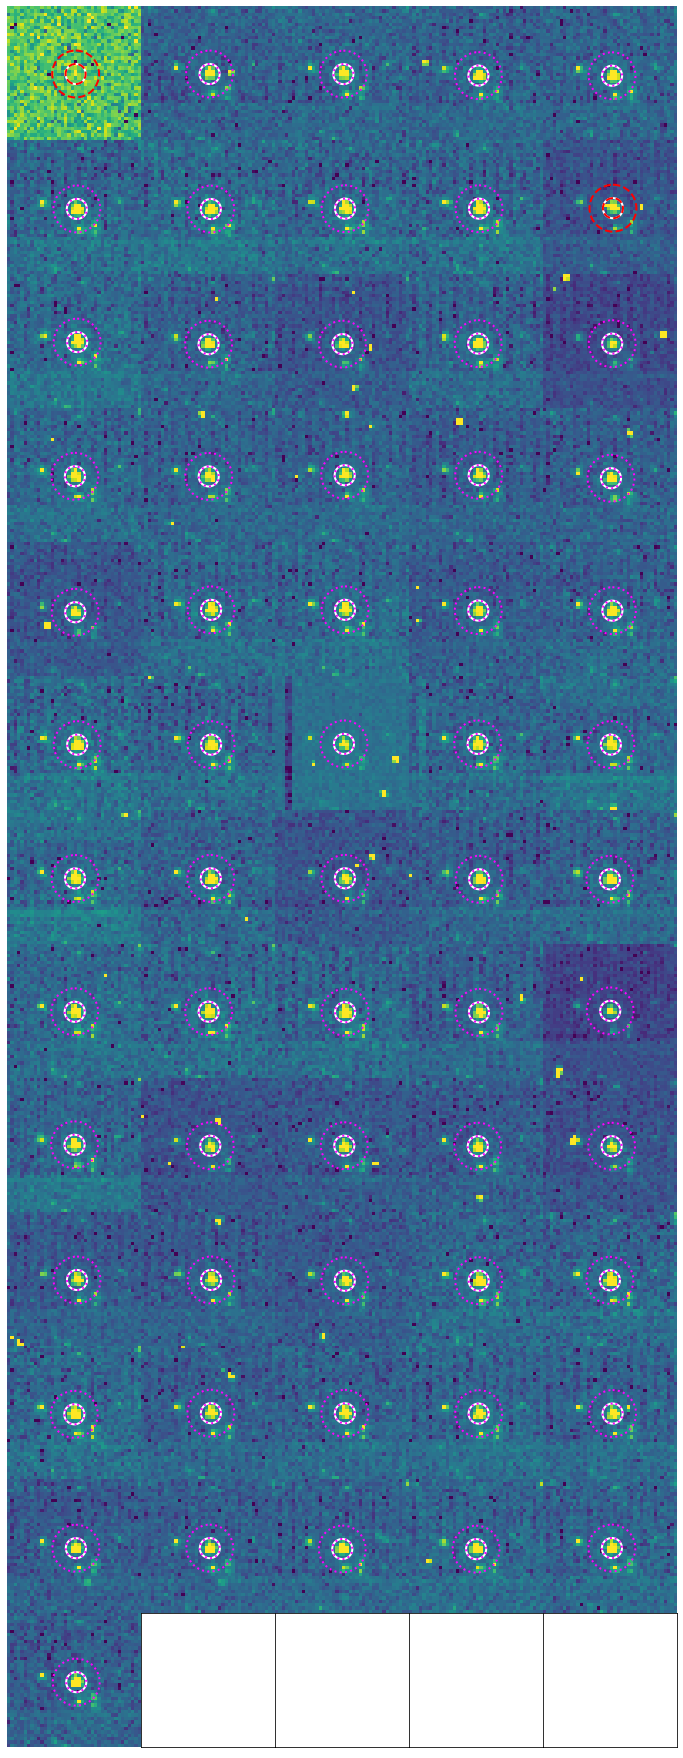

In [7]:
disp_subimages(allchfiles[1], chfiltered[1], aprads, new_center)

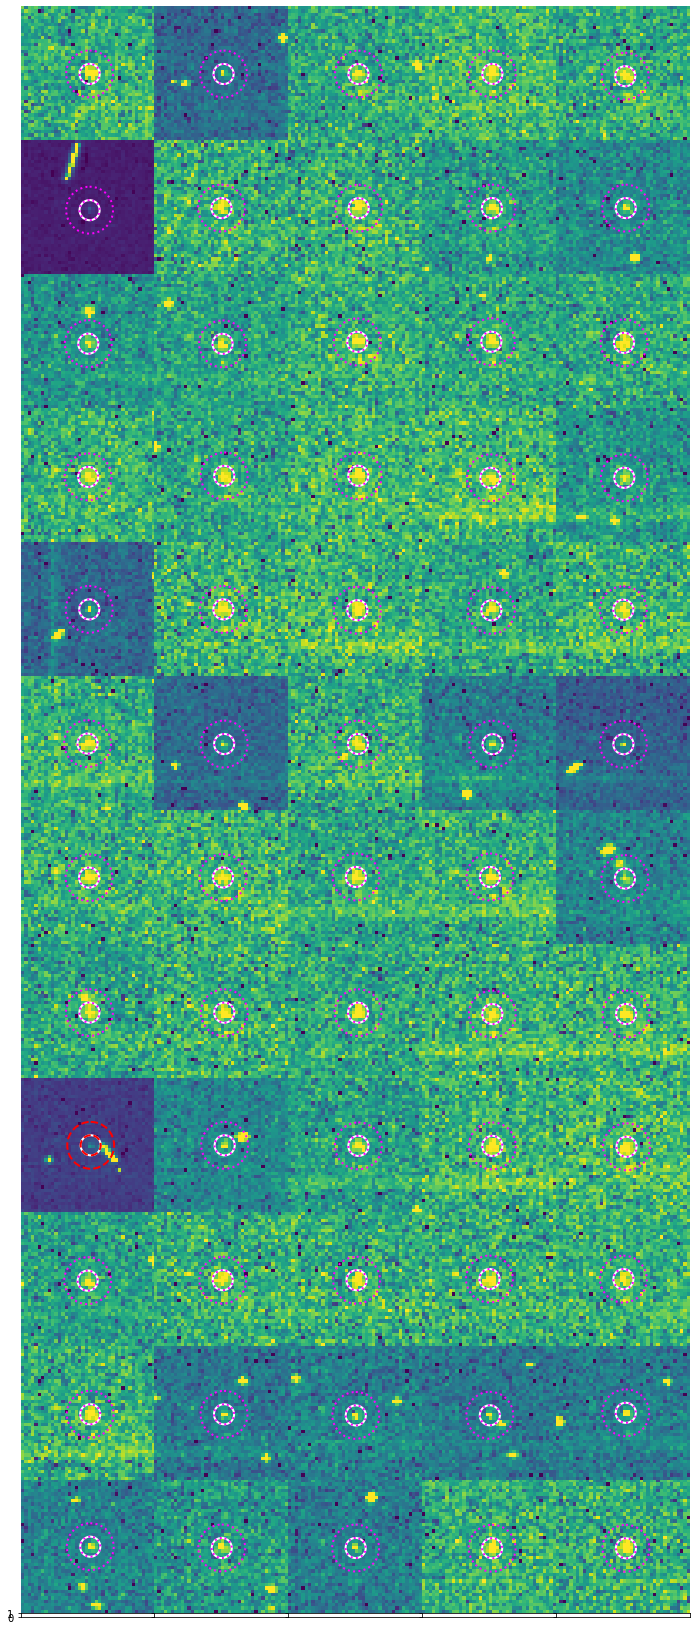

In [8]:
disp_subimages(allchfiles[2], chfiltered[2], aprads, new_center)

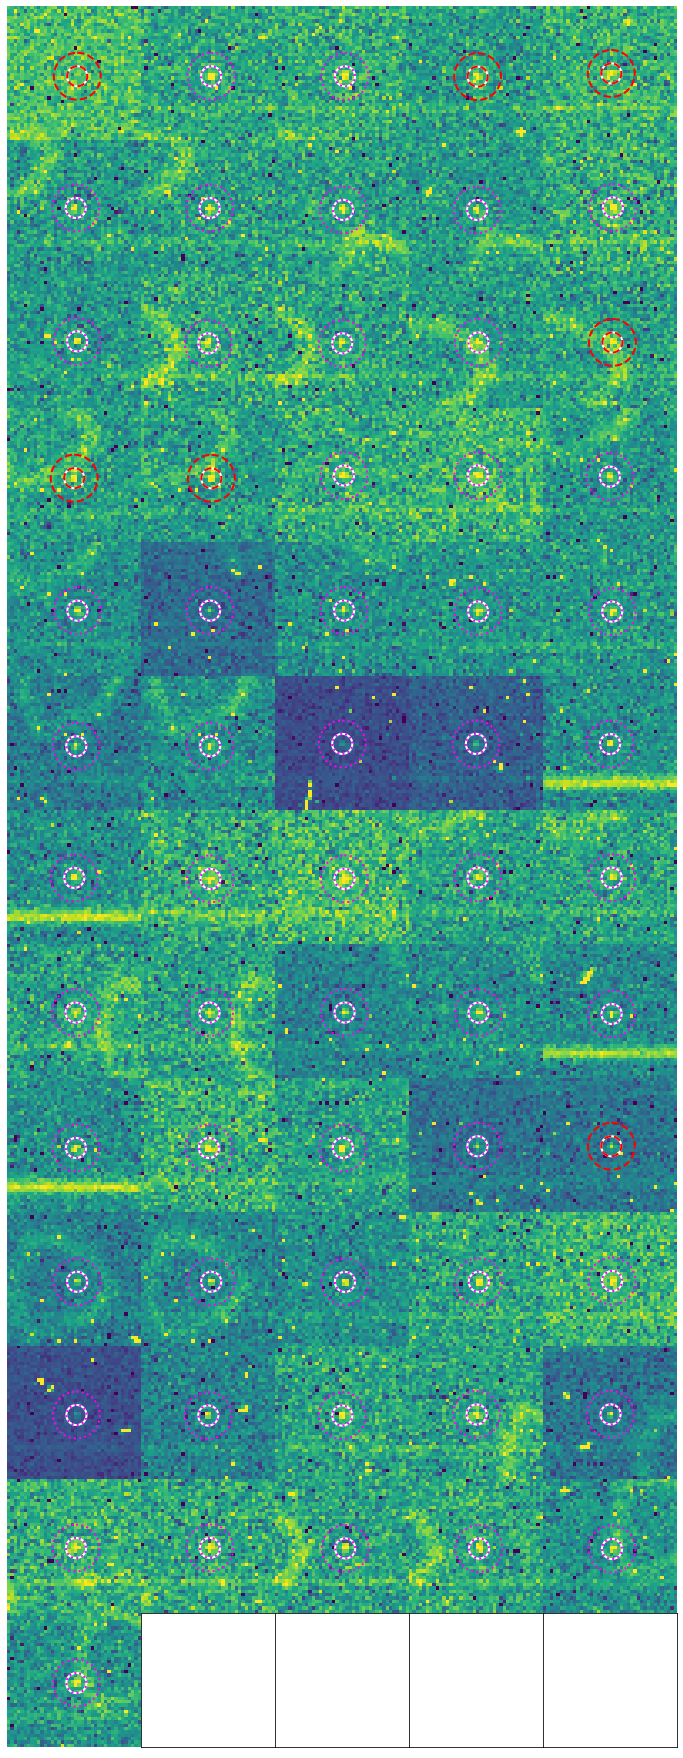

In [9]:
disp_subimages(allchfiles[3], chfiltered[3], aprads, new_center)